In [1]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import os

In [2]:
# def to add cyclic point to a dataarray
def xr_add_cyclic_point(da):
    """
    Inputs
    da: xr.DataArray with dimensions (t,latitude,longitude)
    """

    # Use add_cyclic_point to interpolate input data
    lon_idx = da.dims.index('longitude')
    wrap_data, wrap_lon = add_cyclic_point(da.values, coord=da.longitude, axis=lon_idx)

    # Generate output DataArray with new data but same structure as input
    outp_da = xr.DataArray(data=wrap_data, 
                           coords = {'t': da.t, 'latitude': da.latitude, 'longitude': wrap_lon}, 
                           dims=da.dims, 
                           attrs=da.attrs)
    
    return outp_da

# deal with path
dir_cwd = os.getcwd()
dir_in = '/user/home/nd20983/ancil/cmip7/new_emissions'
dir_scr = '/user/home/nd20983/CMIP7/forcings/emissions/cmip6_data'
filename = 'qrclim.co2.CMIP6_historical.pp.nc'
path = os.path.join(dir_in, filename)
# load dataset
ds = xr.open_dataset(path)
emi = ds.field1561_ua
emi.attrs = ds.field1561_ua.attrs

In [10]:
# emi10 = emi.isel([3170:],dim=['t'])
emi10 = emi.isel(t=slice(3170, None))

In [3]:
# extract vmin/vmax, lon/lat?
vmin = emi.min().values
vmax = emi.max().values
lon = ds.longitude
lat = ds.latitude
time = ds.t

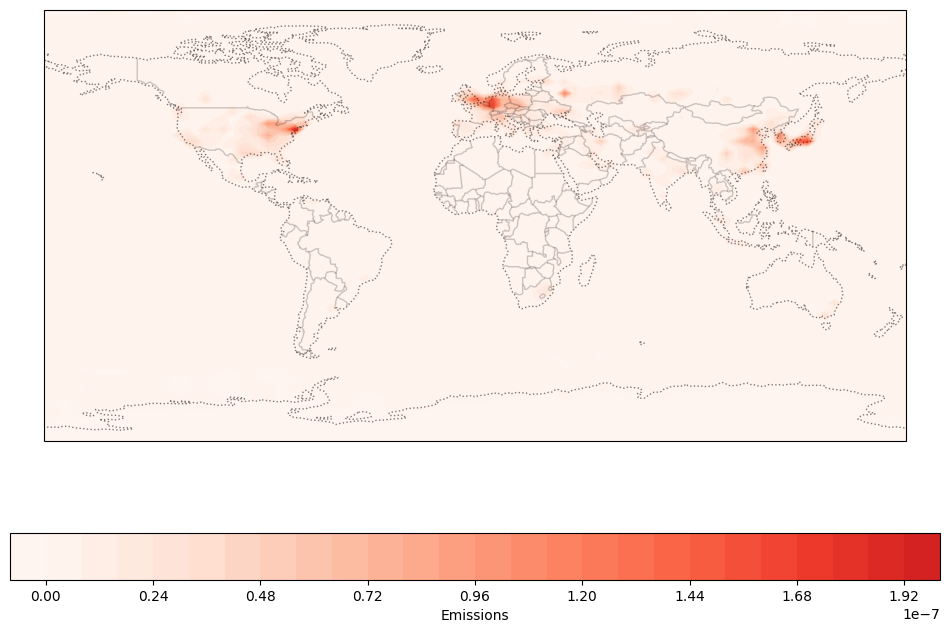

In [4]:
# figure
plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linestyle=':', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.2)
data = emi.isel(t=3000,unspecified=0)
c_data = xr_add_cyclic_point(data)

im = plt.contourf(c_data.longitude, lat, c_data, 30, cmap='Reds',
                  transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,)
cbar = plt.colorbar(im, orientation='horizontal', label='Emissions')

## Method 1 to get animation (slow)

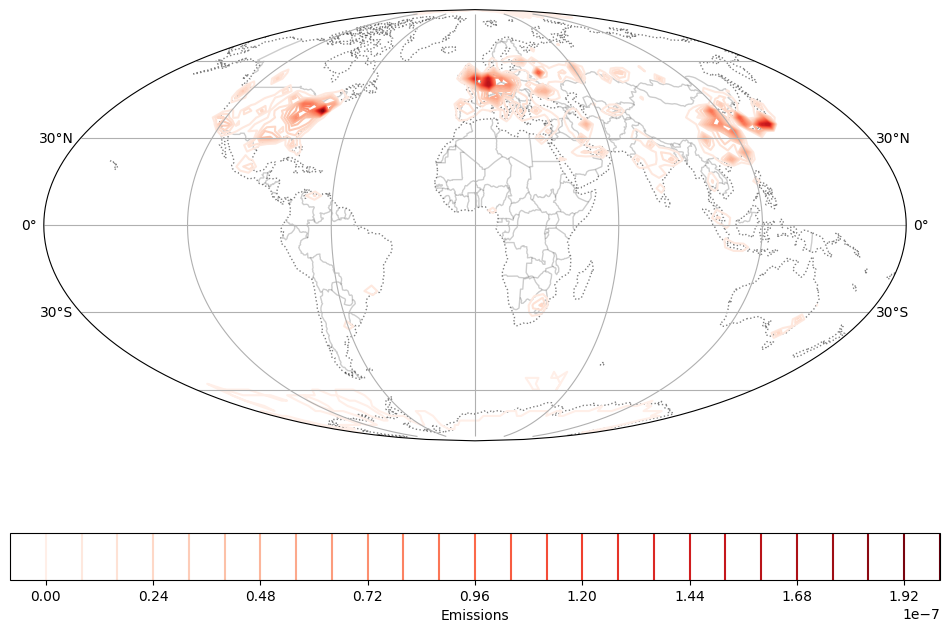

MovieWriter Pillow unavailable; using Pillow instead.


IndexError: list index out of range

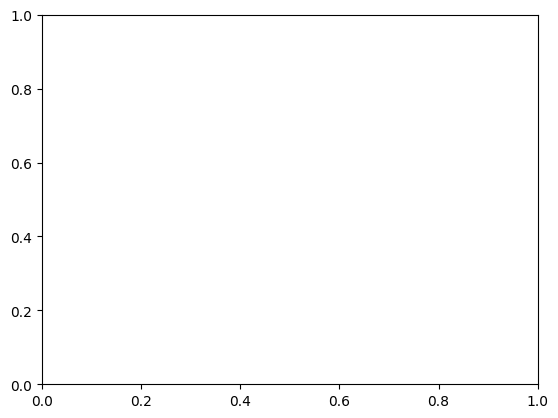

In [16]:
# animation
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mollweide(),)
ax.coastlines(linestyle=':', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.2)
# make the initializing plot
data = xr_add_cyclic_point(emi.isel(t=3000, unspecified=0))
im = plt.contour(data.longitude, data.latitude, data, 30,
             transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(orientation='horizontal', label='Emissions')
gl = ax.gridlines(draw_labels=False)
gl.left_labels = True
gl.right_labels = True

# plot
def update(frame):
   global im, cbar   # Ensure 'im' is modified globally
   # clear ax
   ax.clear()
   ax.coastlines(linestyle=':', alpha=0.5)
   ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.2)
   # update the contour plot
   data = xr_add_cyclic_point(emi.isel(t=frame+3170, unspecified=0))
   #im.set_array(data.values.ravel())
   im = plt.contour(data.longitude, data.latitude, data, 30,
                     transform=ccrs.PlateCarree(), cmap='Reds')
   ax.set_title(f'Global Emissions: Year {(time[frame].values)}')
   return im

ani = animation.FuncAnimation(fig, update, frames=len(time)-3170, interval=20)
plt.show()
path_out = os.path.join(dir_in+'emi.gif')
ani.save('emi.gif', writer='Pillow', fps=30)

## Method 2 to get animation (working)

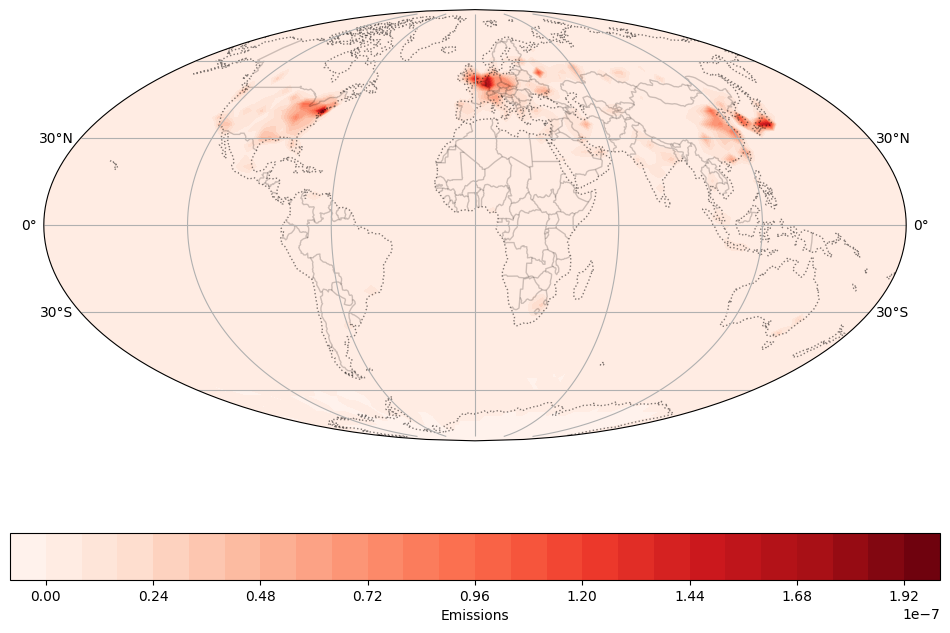

MovieWriter stderr:
[out#0/gif @ 0x55c90a7b37c0] Error writing trailer: Invalid argument



CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1200x800', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-filter_complex', 'split [a][b];[a] palettegen [p];[b][p] paletteuse', '-y', 'emi_test.gif']' returned non-zero exit status 234.

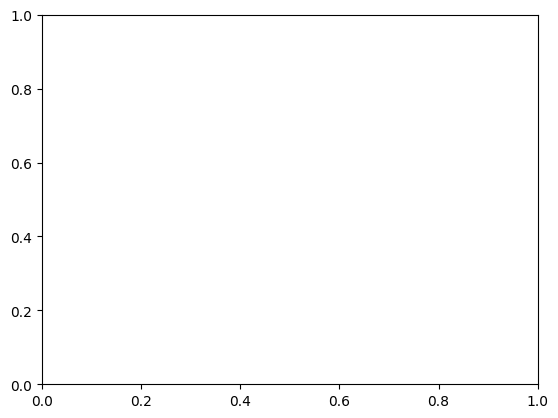

In [ ]:
# animation
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mollweide(),)
ax.coastlines(linestyle=':', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.2)
# make the initializing plot
data = xr_add_cyclic_point(emi.isel(t=3000, unspecified=0))
im = plt.contourf(data.longitude, data.latitude, data, 30,
             transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(orientation='horizontal', label='Emissions')
gl = ax.gridlines(draw_labels=False)
gl.left_labels = True
gl.right_labels = True

# get all the data for plotting
data_bucket = []
for i in range(len(time)):
   data = xr_add_cyclic_point(emi.isel(t=i, unspecified=0))
   data_bucket.append(data)
# plot
def update(frame):
   global cbar, im
   #data = xr_add_cyclic_point(emi.isel(t=frame+3000, unspecified=0))
   data_plot = data_bucket[frame]
   im.set_array(data_plot.values.ravel())
   ax.set_title(f'Global Emissions: Year {(time[frame].values)}')
   return im

ani = animation.FuncAnimation(fig, update, frames=len(time)-3000, interval=20)
plt.show()
ani.save('emi_test.gif', writer='ffmpeg', fps=30)

In [ ]:
# animation
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection=ccrs.Mollweide())
ax.coastlines(linestyle=':', alpha=0.5)
ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=0.2)

# initialize plot
initial_data = xr_add_cyclic_point(emi.isel(t=3000, unspecified=0))
im = plt.contourf(initial_data.longitude, initial_data.latitude, initial_data, 30,
             transform=ccrs.PlateCarree(), cmap='Reds')
cbar = plt.colorbar(orientation='horizontal', label='Emissions')
gl = ax.gridlines(draw_labels=False)
gl.left_labels = True
gl.right_labels = True

# Efficient data handling
emi_cyclic = xr_add_cyclic_point(emi)
data_bucket = [emi_cyclic.isel(t=i, unspecified=0) for i in range(len(time))]

# update function
def update(frame):
    data_plot = data_bucket[frame]
    im.set_array(data_plot.values.ravel())
    ax.set_title(f'Global Emissions: Year {time[frame].values}')
    return im

ani = animation.FuncAnimation(fig, update, frames=len(time)-3000, interval=20)
plt.show()
ani.save('emi_optimized.gif', writer='ffmpeg', fps=30)